<a href="https://colab.research.google.com/github/aaronmj7/Time-Series-Modelling-Case-Study/blob/main/ART_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00


In [ ]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

from scipy.fft import fft, fftfreq

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense

from keras.utils import set_random_seed
import warnings

In [ ]:
# define necessary functions
def check_dup(df):
  ''' Function to check number of duplicates in a dataframe.
    Args:
      df: A dataframe.
  '''

  dups = df.duplicated()
  print(f'Number of duplicated rows = {dups.sum()}')
  return


def plot_acf_pacf(values):
  ''' Function to plot autocorrelation and partial autocorrelation functions.
  Args:
    values: An array of values to be ploted.
  '''

  fig, ax = plt.subplots(2, 1, figsize=(17, 9))

  lag = len(values) - 1

  plot_acf(values, lags=lag, ax=ax[0])
  plot_pacf(values, lags=(lag // 2), ax=ax[1])

  ax[1].set_xlabel('Lag')
  return


def adfuller_test(ts):
  ''' Function to perform ADF test and print detailed result.
  Args:
    ts: An array of a time series.
  '''

  result=adfuller(ts)
  labels = ['ADF Test Statistic','p-value','#Lags Used',
            'Number of Observations Used']

  for value, label in zip(result, labels):
      print(label+' : '+str(value) )

  #Ho: It is non stationary
  #H1: It is stationary
  if result[1] <= 0.05:
      print("P value is less than 0.05 that means we can reject the",
            "null hypothesis(Ho).")
      print("--> Therefore we can conclude that data has no unit root and",
            "is stationary")
  else:
      print("Weak evidence against null hypothesis that means time series",
            "has a unit root")
      print("--> Indicates the time series is non-stationary ")
  return


def plot_line_hist(values, title):
  ''' Function to plot a line graph and histogram.
  Args:
    values: An array to be plotted.
    title: A string to add in the title.
  '''

  fig, ax = plt.subplots(1, 2, figsize=(17,5))

  # plot line plot
  ax[0].plot(values)
  title1 = str(title) + ' transformed Data'
  ax[0].set_title(title1)

  # plot histogram
  ax[1].hist(values)
  title2 = 'Distribution of ' + str(title) + ' transformed Data'
  ax[1].set_title(title2)
  return


def best_arima(ts, max_p=8, max_d=1, max_q=8):
  ''' Function to find the best ARIMA model with the least AIC value.
  Returns a tuple of the p, d, q values with the least AIC value.
  Args:
    ts: An array of time series to be fitted.
    max_p: Maximum value for p.
    max_d: Maximum value for d.
    max_q: Maximum value for q.
  '''

  # create required empty lists
  pdq = []
  aic_list = []

  # loop over all combinations of p, d and q
  for p in range(max_p + 1):
    for d in range(max_d + 1):
      for q in range(max_q + 1):
        try:

          # fit ARIMA model
          model = ARIMA(ts, order=(p,d,q))
          result = model.fit()
          # record AIC value
          aic = result.aic
          # record p,d,q values
          pdq.append((p, d, q))
          aic_list.append(aic)

        except:
          continue # to skip if the model fails to fit

  # find p, d, q with the least AIC value
  best_pdq = pdq[np.argmin(aic_list)]
  print(f'ARIMA{best_pdq} has the least AIC for the given time series.')

  return best_pdq, pd.DataFrame({'pdq': pdq, 'AIC': aic_list})


def plot_forecast(ts, future_dates, predict, n_forecast):
  """ Function to plot forecast of a time series.
  Args:
    ts: A list of time series to be plotted.
    future_dates: A list of future dates.
    predict: Predict from the model.
    n_forecast: Number of forecast.
  """

  plt.figure(figsize=(15,5))

  # plot the data
  plt.plot(ts)

  # plot the forecast
  plt.plot(future_dates, predict.predicted_mean[(-n_forecast)-1:], 'k--',
           label='forecast')

  # plot the confidence interval
  plt.fill_between(future_dates, predict.conf_int().iloc[(-n_forecast)-1:, 0],
                  predict.conf_int().iloc[(-n_forecast)-1:, 1], color='orange',
                  alpha=0.3, label='confidence interval')
  plt.xlabel('Date')
  plt.legend()
  return


def periodogram(ts):
  """ Function to plot a preiodogram.
  Args:
    ts: A list of time series to be plotted.
  """

  # sample spacing
  T = 1.0 / len(ts)

  # perform fft
  yf = fft(ts)
  xf = fftfreq(len(ts), T)[:len(ts)//2]
  per = 2.0/len(ts) * np.abs(yf[0:len(ts)//2])

  # plot periodigram
  plt.figure(figsize=(13,7))
  plt.stem(xf, per, markerfmt='')
  plt.xlabel('Frequency(Hz)')
  plt.ylabel('Amplitude')
  return


def timeseries_to_supervised(data, lag=1):
  """ Function to transform data to be supervised learning.
  Returns the transformed dataframe.
  Args:
    data: A list of data to be transformed.
    lag: Number of lag needed.
    """

  df = pd.DataFrame(data)
  columns = [df.shift(i) for i in range(1, lag+1)]
  columns.append(df)
  df = pd.concat(columns, axis=1)
  df.fillna(0, inplace=True)
  return df


def scale(train, test):
  """ Function to scale train and test data to [-1, 1]
  Returns the scaler, scaled train and test data.
  Args:
    train: A list of train data to be scaled.
    test: A list of test data to be scaled.
    """

  # fit scaler
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler = scaler.fit(train)

  # transform train
  train = train.reshape(train.shape[0], train.shape[1])
  train_scaled = scaler.transform(train)

  # transform test
  test = test.reshape(test.shape[0], test.shape[1])
  test_scaled = scaler.transform(test)
  return scaler, train_scaled, test_scaled


def fit_lstm(train, batch_size, nb_epoch, neurons):
  """Function to fit an LSTM network to training data.
  Returns the model.
  Args:
    train: Data to be trained.
    batch_size: Batch size for training.
    nb_epoch: Number of epochs.
    neurons: Number of neurons.
  """

  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])

  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')

  for i in range(nb_epoch):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
  return model


def forecast_lstm(model, batch_size, X):
  """ Function to make a one-step forecast.
  Returns the forecast.
  Args:
    model: Model to forecast the data.
    batch_size: Batch size used.
    X: Data to be forecasted.
  """

  X = X.reshape(1, 1, len(X))
  yhat = model.predict(X, batch_size=batch_size)
  return yhat[0,0]


def invert_scale(scaler, X, value):
  """ Function to inverse scaling.
  Returns the inverted data.
  Args:
    scaler: Scaler used to scale the data before.
    X: Original data.
    value: Value to be inverted.
  """

  new_row = [x for x in X] + [value]
  array = np.array(new_row)
  array = array.reshape(1, len(array))
  inverted = scaler.inverse_transform(array)
  return inverted[0, -1]


def inverse_difference(history, yhat, interval=1):
  """ Function to inverse the differencing.
  Returns the inverted data.
  Args:
    history: Original data.
    yhat: Data to be inverted.
    interval: Interval used.
  """
  return yhat + history[-interval]

In [ ]:
warnings.filterwarnings('ignore')

%matplotlib inline

# set seaborn theme
sns.set_theme()

# Set random seed to get same result each time
set_random_seed(7)

# Johnson & Johnson

## Load Data

In [ ]:
# read in data file
jj_df = pd.read_csv('/content/drive/MyDrive/jj.csv')
# display the data
jj_df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [ ]:
# display info
jj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


## Data Preprocessing

In [ ]:
# check for duplicates
check_dup(jj_df)

Number of duplicated rows = 0


In [ ]:
# convert the 'date' column to datetime format
jj_df['date']= pd.to_datetime(jj_df['date'])

In [ ]:
# set index
jj_df.set_index('date', inplace=True)
jj_df.head()

,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


In [ ]:
# analyse the data
jj_df.describe()

,data
count,84.000000
mean,4.799762
std,4.309991
min,0.440000
25%,1.247500
50%,3.510000
75%,7.132500
max,16.200000


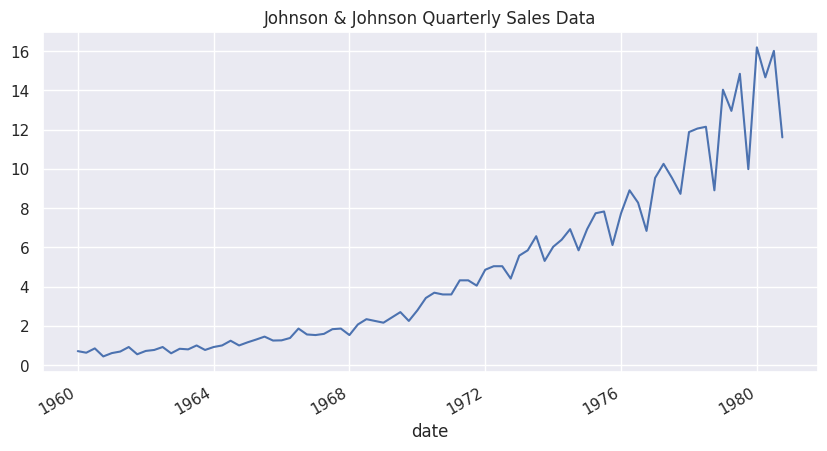

In [ ]:
# plot the time series # maybe function
jj_df.plot(legend=False, title='Johnson & Johnson Quarterly Sales Data',
           figsize=(10,5))
plt.show()

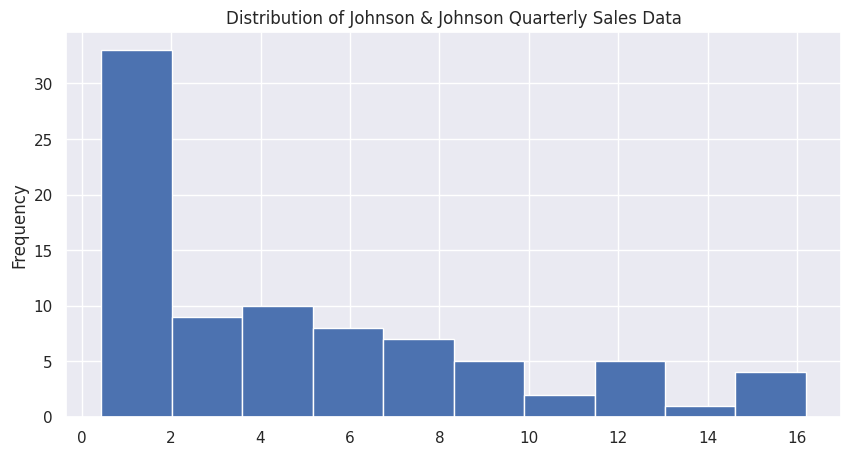

In [ ]:
# plot histogram
jj_df.plot(kind='hist', legend=False, figsize=(10,5),
           title='Distribution of Johnson & Johnson Quarterly Sales Data')
plt.show()

## Stationarity

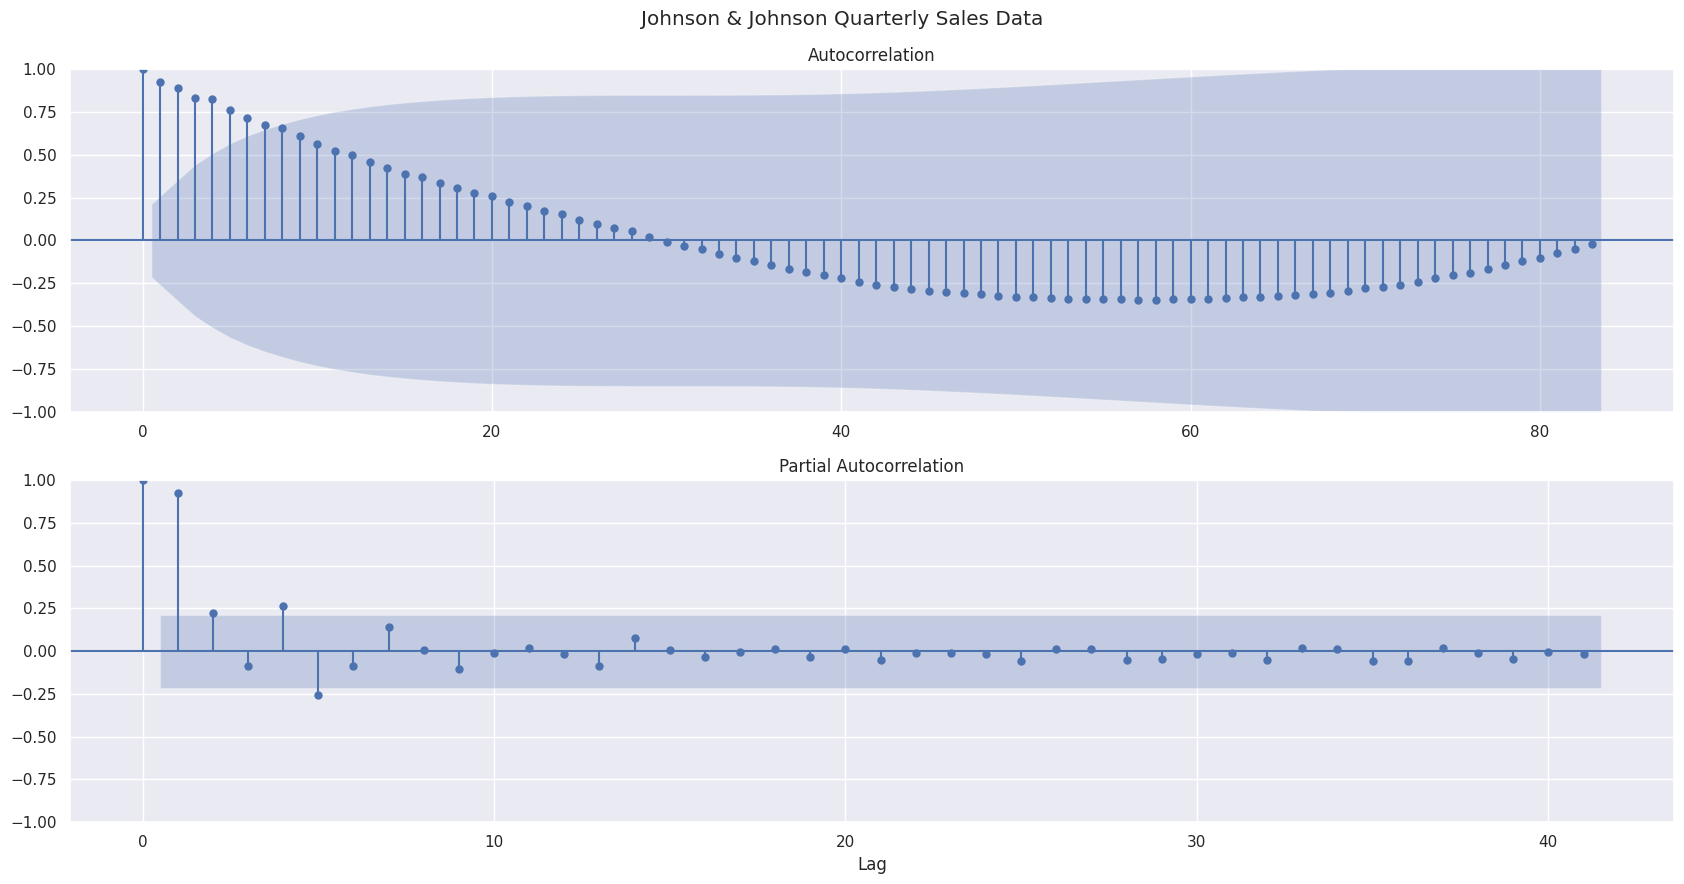

In [ ]:
# plot ACF and PACF
plot_acf_pacf(jj_df['data'])
plt.suptitle('Johnson & Johnson Quarterly Sales Data')
plt.tight_layout()
plt.savefig('jj_acf.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# perform ADF test
adfuller_test(ts=jj_df['data'])

ADF Test Statistic : 2.7420165734574744
p-value : 1.0
#Lags Used : 11
Number of Observations Used : 72
Weak evidence against null hypothesis that means time series has a unit root
--> Indicates the time series is non-stationary 


In [ ]:
# find best lambda
boxcox_jj, lam = boxcox(jj_df['data'])

# print lambda
print(f'Lambda = {lam}')

Lambda = 0.05071029569161342


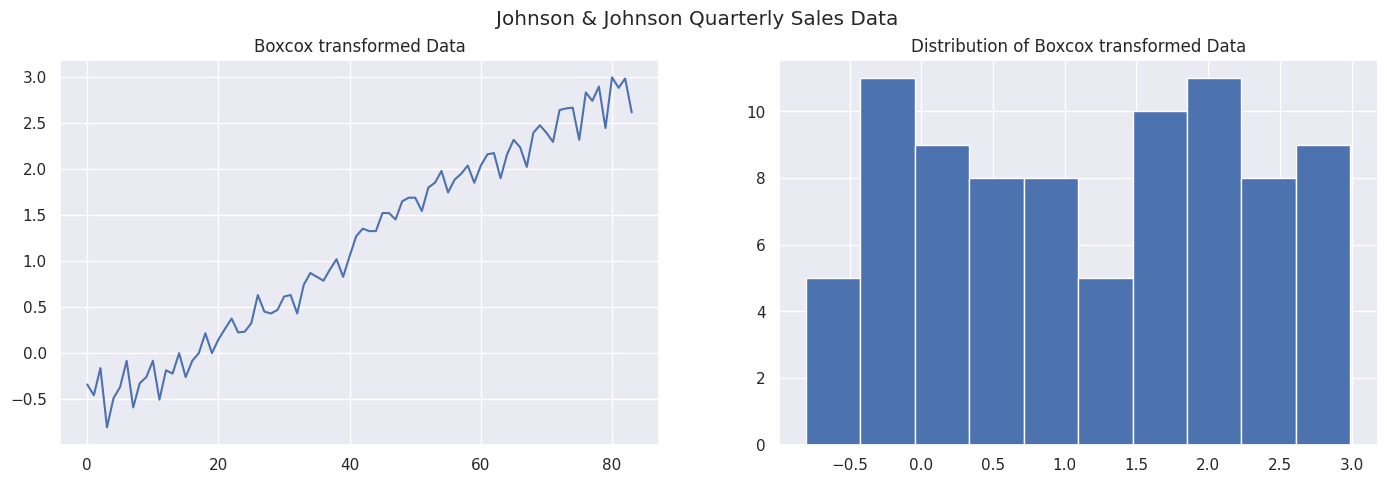

In [ ]:
# plot line plot and histogram
plot_line_hist(boxcox_jj, 'Boxcox')
plt.suptitle('Johnson & Johnson Quarterly Sales Data')
plt.show()

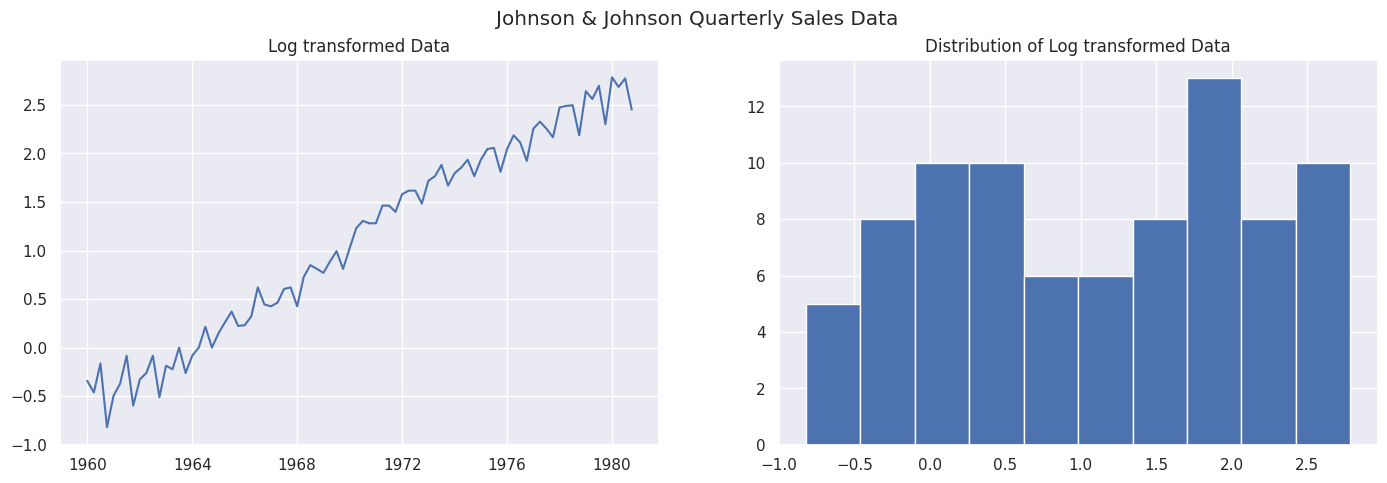

In [ ]:
# perform log transformation as lamda value of boxcox is close to zero
log_jj = np.log(jj_df['data'])

# plot
plot_line_hist(log_jj, 'Log')
plt.suptitle('Johnson & Johnson Quarterly Sales Data')
plt.show()

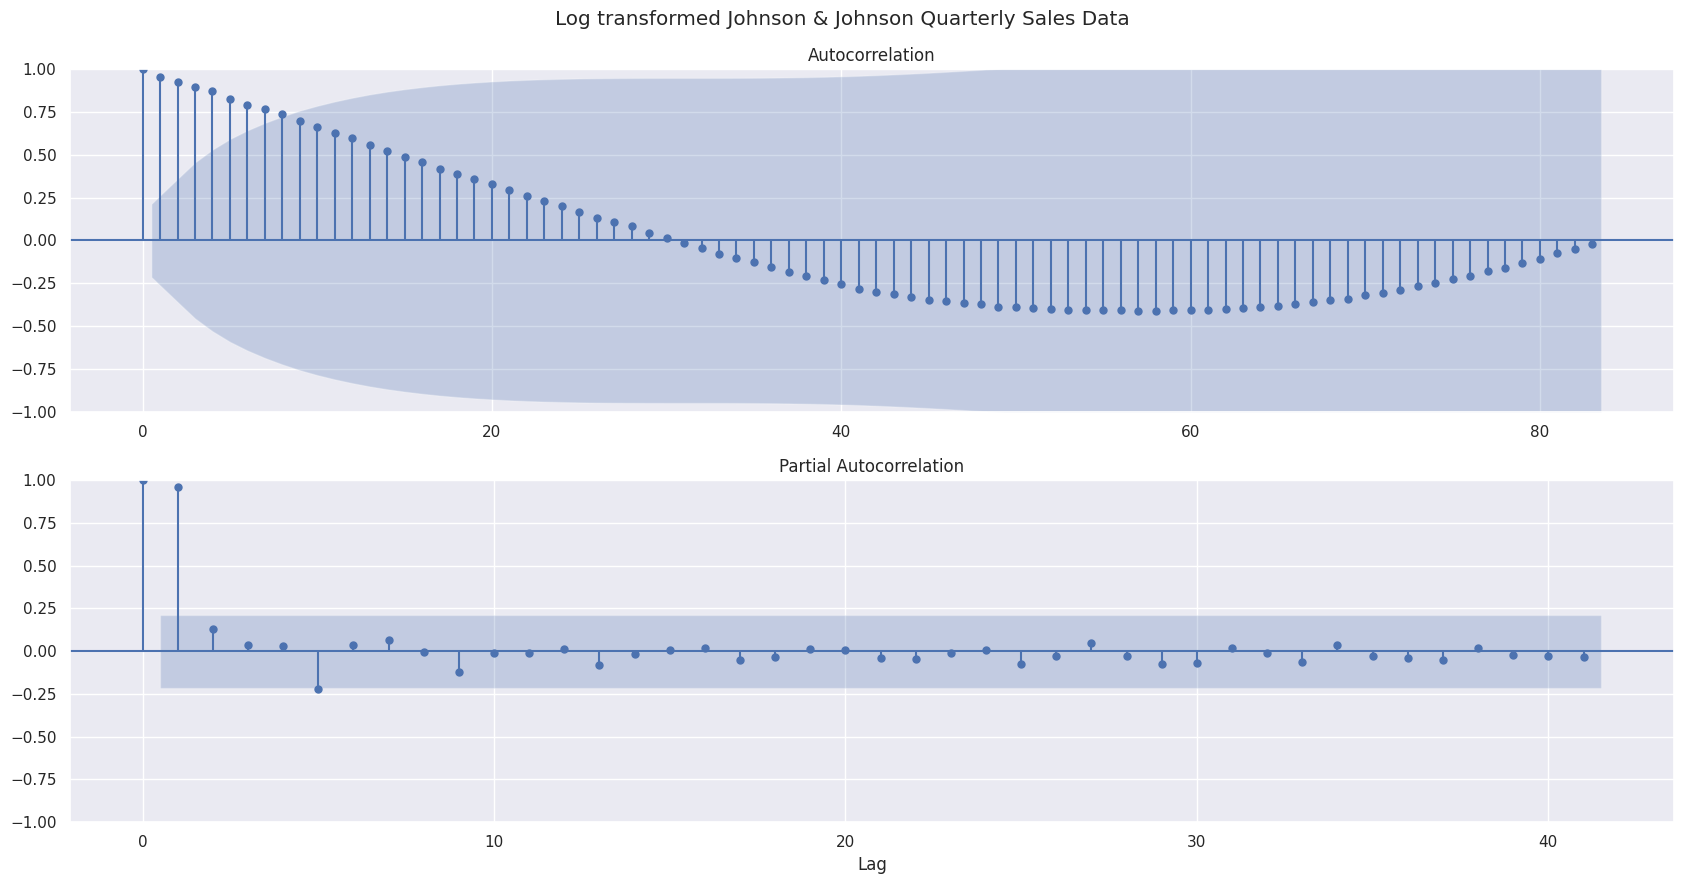

In [ ]:
# plot ACF and PACF
plot_acf_pacf(log_jj)
plt.suptitle('Log transformed Johnson & Johnson Quarterly Sales Data')
plt.tight_layout()
plt.show()

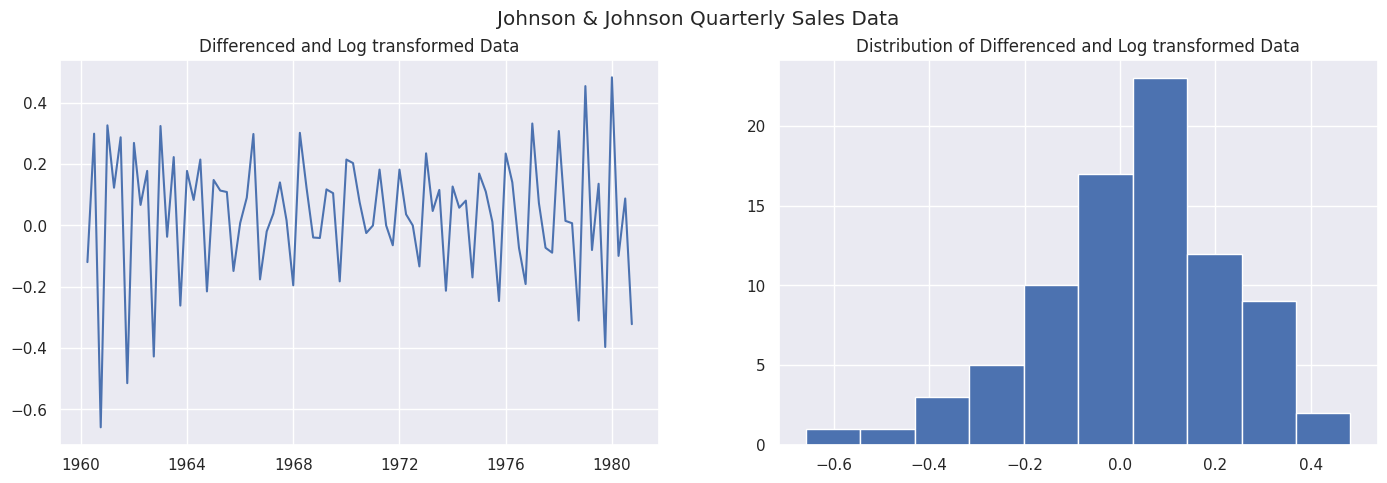

In [ ]:
# use the differencing operator
diff_log_jj = log_jj.diff().dropna()

# plot
plot_line_hist(diff_log_jj, 'Differenced and Log')
plt.suptitle('Johnson & Johnson Quarterly Sales Data')
plt.savefig('diff_log_jj_line_hist.png', dpi=300, bbox_inches="tight")
plt.show()

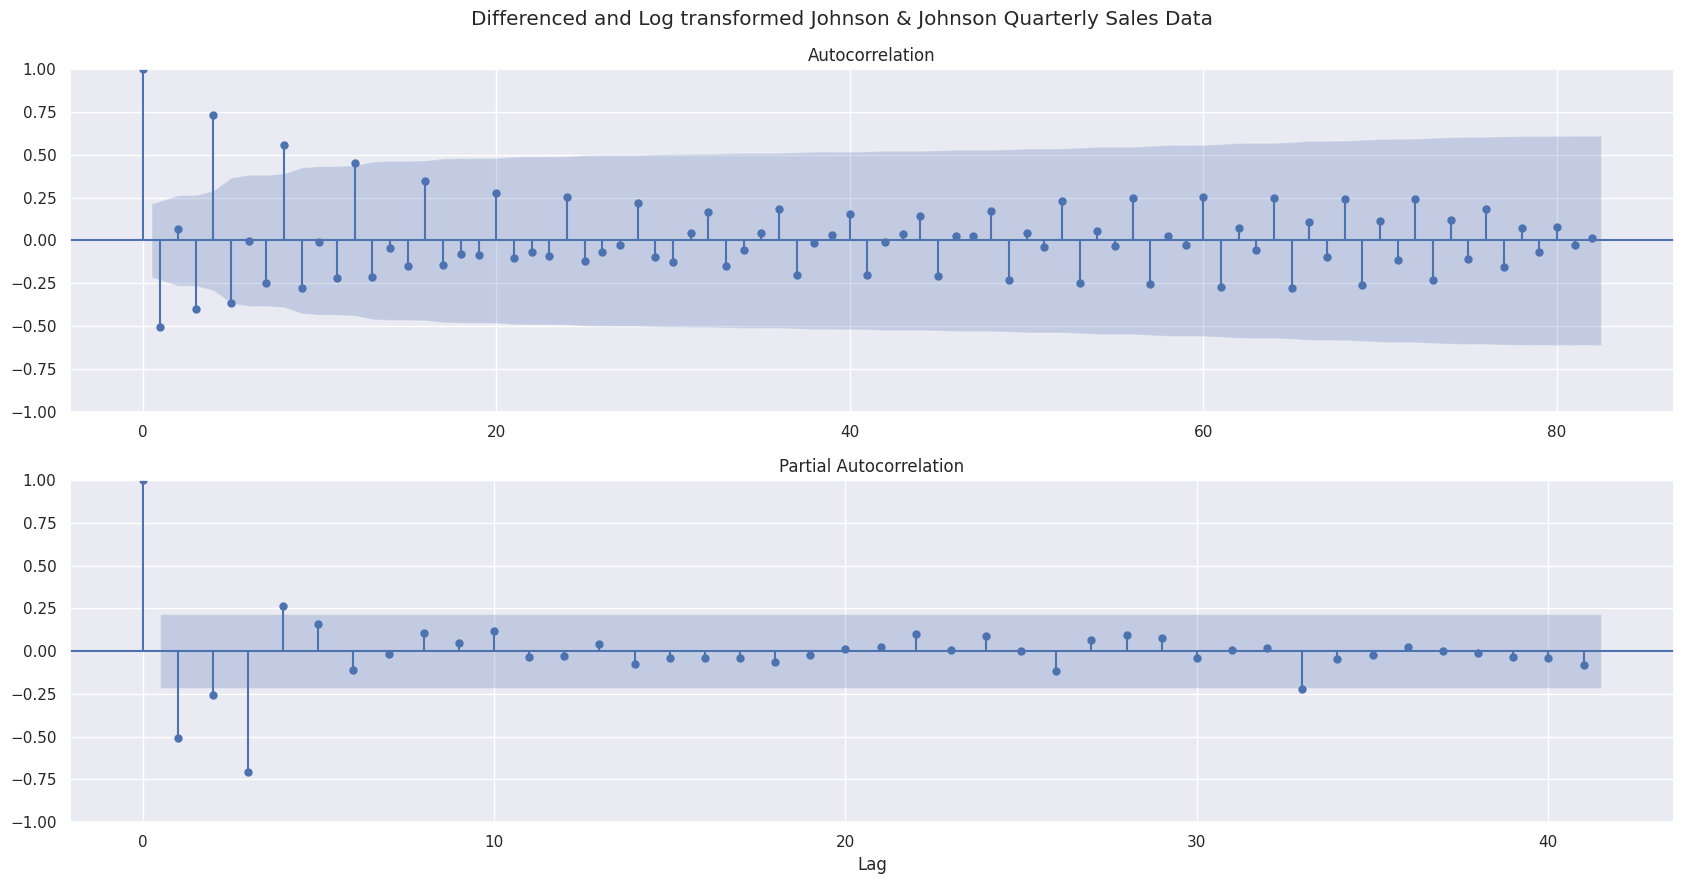

In [ ]:
# plot ACF and PACF
plot_acf_pacf(diff_log_jj)
plt.suptitle('Differenced and Log transformed Johnson & Johnson Quarterly Sales Data')
plt.tight_layout()
plt.savefig('diff_log_jj_acf.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# perform ADF test
adfuller_test(ts=diff_log_jj)

ADF Test Statistic : -4.317043945811837
p-value : 0.00041497314044406584
#Lags Used : 5
Number of Observations Used : 77
P value is less than 0.05 that means we can reject the null hypothesis(Ho).
--> Therefore we can conclude that data has no unit root and is stationary


## ARIMA

In [ ]:
# find best order of arima model with the least AIC
best_order_least_aic, pdq_df = best_arima(ts=jj_df['data'].tolist())

ARIMA(6, 1, 3) has the least AIC for the given time series.


In [ ]:
# define the ARIMA model with the best order on actual data
model = ARIMA(jj_df['data'], order=best_order_least_aic)

# fit the model
model_fit = model.fit()
# inspect the summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 -47.649
Date:                Wed, 01 May 2024   AIC                            115.297
Time:                        07:06:25   BIC                            139.486
Sample:                             0   HQIC                           125.015
                                 - 84                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4733      0.127    -11.640      0.000      -1.721      -1.225
ar.L2         -0.7728      0.148     -5.235      0.000      -1.062      -0.484
ar.L3          0.0382      0.063      0.610      0.542      -0.085       0.161
ar.L4          1.0151      0.045     22.310      0.000       0.926       1.104
ar.L5          1.4356      0.134     10.685      0.000       1.172       1.699
ar.L6          0.7430      0.149      4.985      0.000       0.451       1.035
ma.L1          0.7232      0.126      5.731      0.000       0.476       0.970
ma.L2         -0.1461      0.113     -1.294      0.196      -0.367       0.075
ma.L3         -0.7213      0.081     -8.940      0.000      -0.879      -0.563
sigma2         0.1543      0.024      6.310      0.000       0.106       0.202
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                65.05
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):              39.65   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

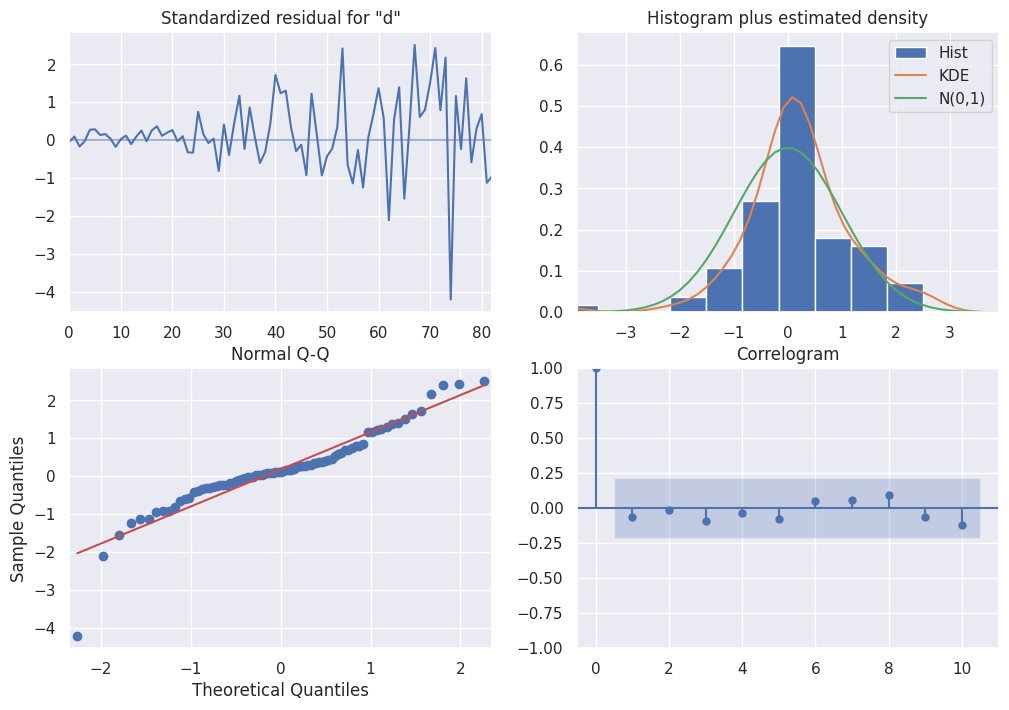

In [ ]:
# plot diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

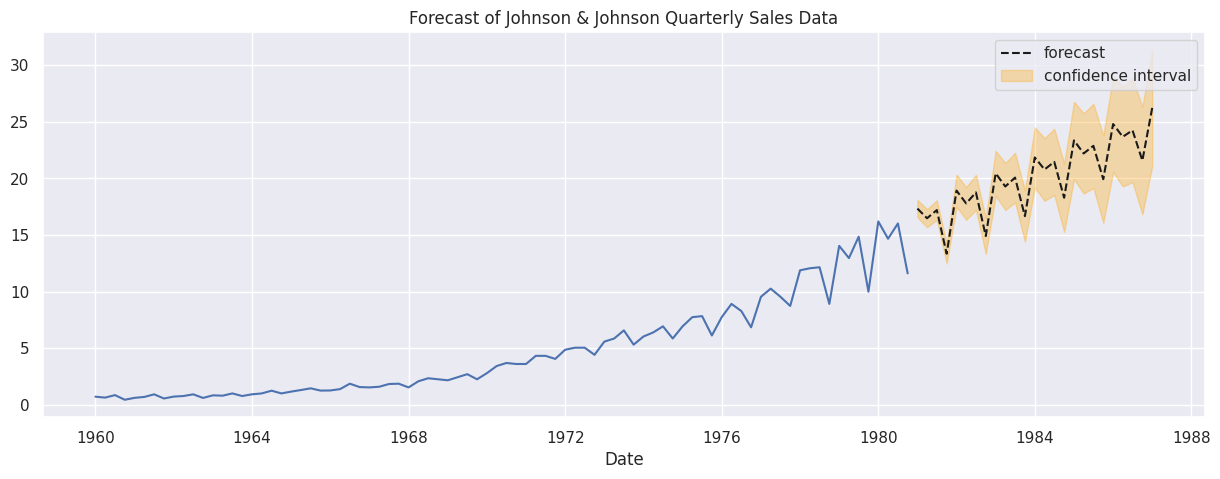

In [ ]:
# get the forecast
n_forecast = 24
predict = model_fit.get_prediction(end=model.nobs + n_forecast)

# create the date range for the forecast period
future_dates = pd.date_range(start=jj_df.index[-1], periods=n_forecast + 1, freq='Q')
# convert to the same format
future_dates = future_dates.to_period(jj_df.index.freq)

# plot forecast
plot_forecast(ts=jj_df['data'], future_dates=future_dates, predict=predict,
              n_forecast=n_forecast)
plt.title('Forecast of Johnson & Johnson Quarterly Sales Data')
plt.savefig('jj_forecast.png', dpi=300, bbox_inches="tight")
plt.show()

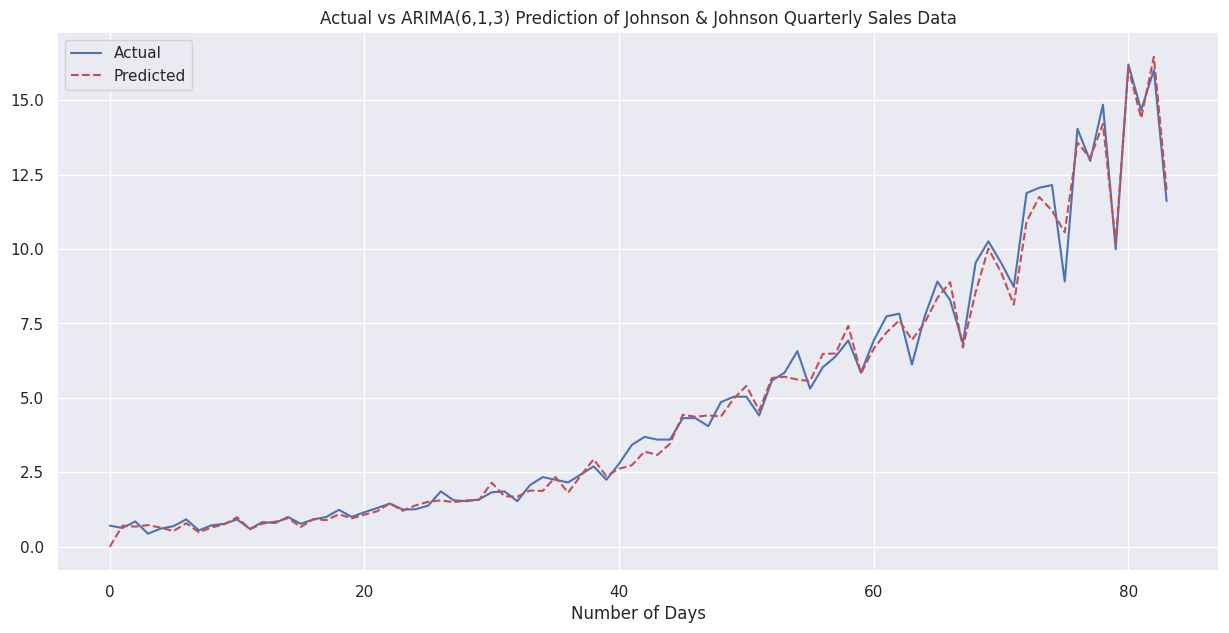

In [ ]:
# evaluate the model
plt.figure(figsize=(15,7))
plt.plot(jj_df['data'].tolist(), label='Actual')
plt.plot(predict.predicted_mean[:model.nobs], 'r--', label='Predicted')
plt.xlabel('Number of Days')
plt.title('Actual vs ARIMA(6,1,3) Prediction of Johnson & Johnson Quarterly Sales Data')
plt.legend()
plt.savefig('arima613_jj.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(jj_df['data'], predict.predicted_mean[:model.nobs]))
print('RMSE =', np.round(rmse, 3))

RMSE = 0.4


In [ ]:
# find best order of arima model with auto_arima
auto_arima_model = auto_arima(jj_df['data'].tolist(), stepwise=False)

# obtain best order
best_order_auto = auto_arima_model.order
best_order_auto

(4, 1, 1)

In [ ]:
# define the ARIMA model with the best order on actual data
model = ARIMA(jj_df['data'], order=best_order_auto)

# fit the model
model_fit = model.fit()
# inspect the summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(4, 1, 1)   Log Likelihood                 -54.691
Date:                Wed, 01 May 2024   AIC                            121.382
Time:                        07:06:36   BIC                            135.895
Sample:                             0   HQIC                           127.212
                                 - 84                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0345      0.032     -1.076      0.282      -0.097       0.028
ar.L2          0.0198      0.034      0.584      0.559      -0.047       0.086
ar.L3          0.0320      0.031      1.039      0.299      -0.028       0.092
ar.L4          0.9614      0.031     30.579      0.000       0.900       1.023
ma.L1         -0.7525      0.072    -10.412      0.000      -0.894      -0.611
sigma2         0.1914      0.025      7.610      0.000       0.142       0.241
===================================================================================
Ljung-Box (L1) (Q):                   3.18   Jarque-Bera (JB):                56.66
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):              54.30   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

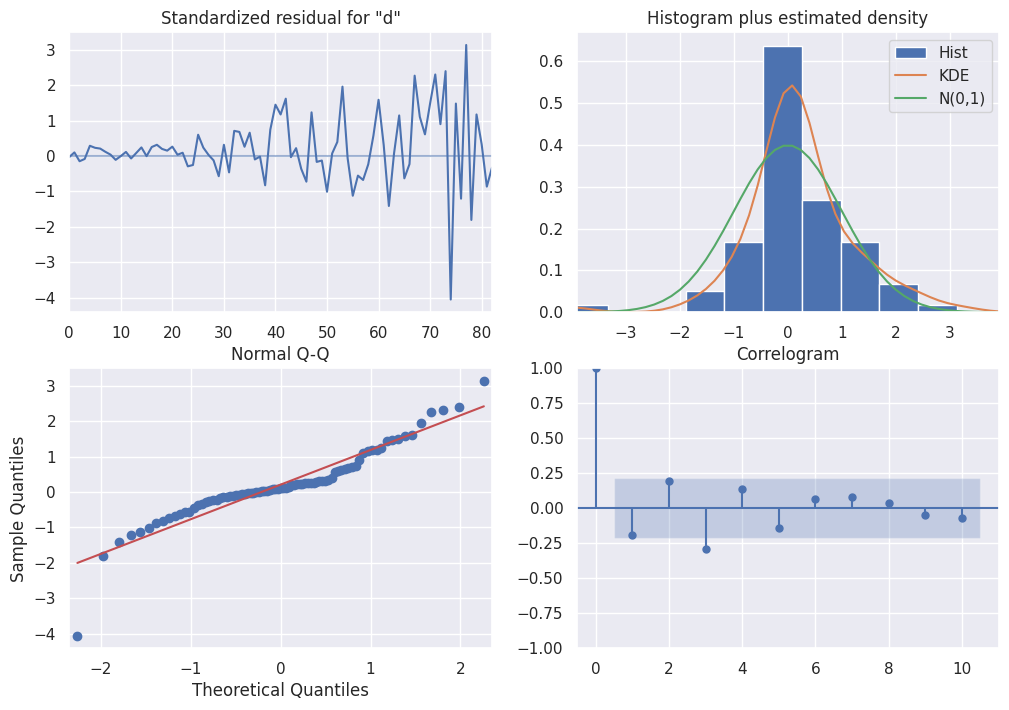

In [ ]:
# plot diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

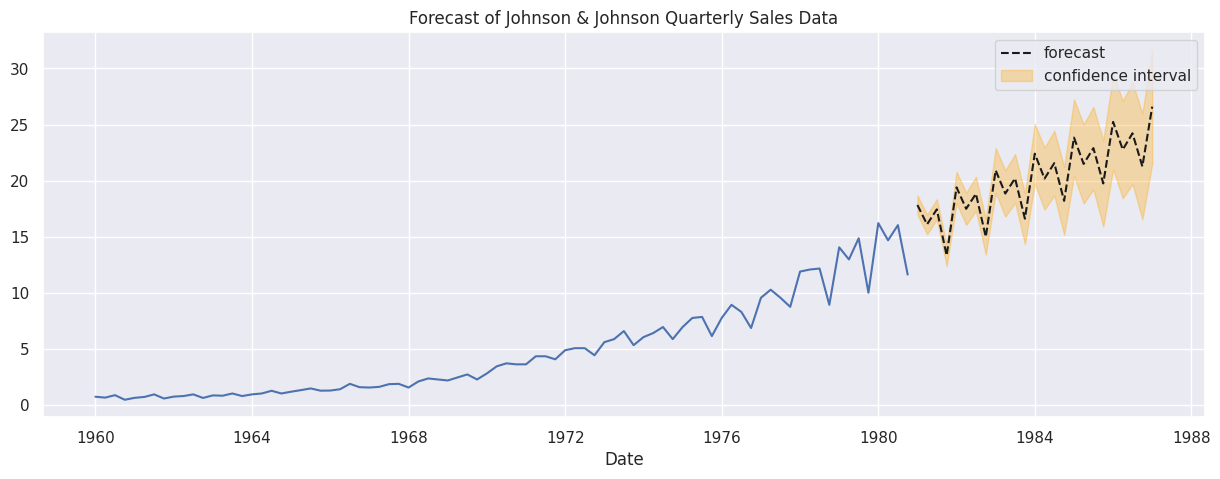

In [ ]:
# get the forecast
n_forecast = 24
predict = model_fit.get_prediction(end=model.nobs + n_forecast)

# create the date range for the forecast period
future_dates = pd.date_range(start=jj_df.index[-1], periods=n_forecast + 1, freq='Q')
# convert to the same format
future_dates = future_dates.to_period(jj_df.index.freq)

# plot forecast
plot_forecast(jj_df['data'], future_dates, predict, n_forecast)
plt.title('Forecast of Johnson & Johnson Quarterly Sales Data')
plt.show()

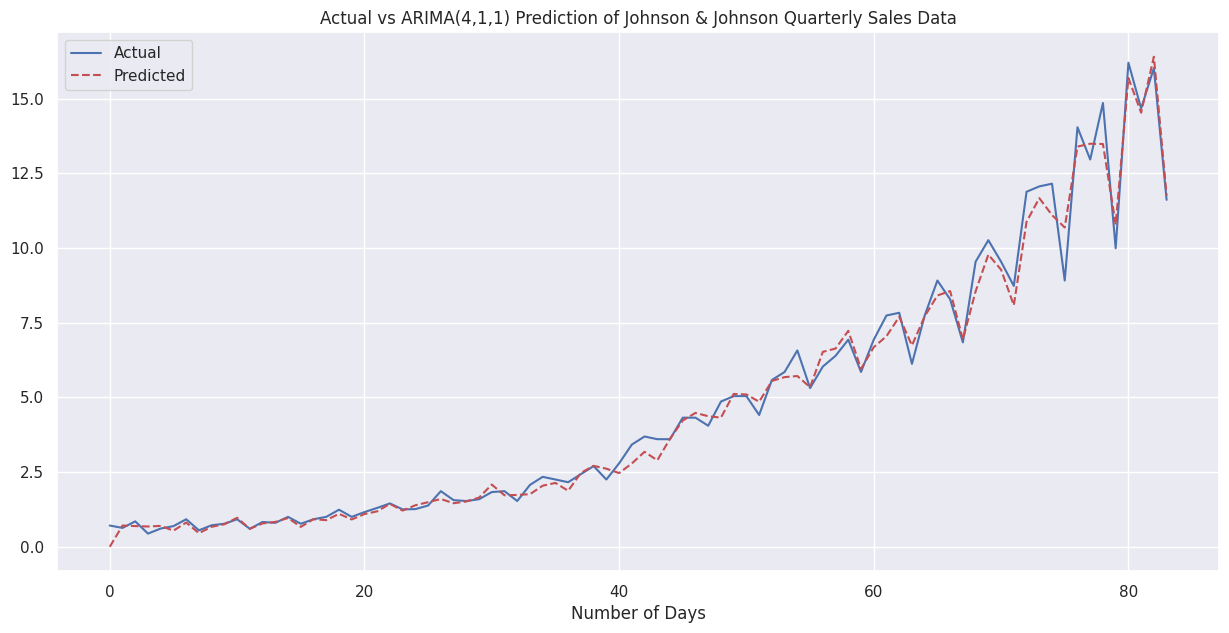

In [ ]:
# evaluate the model
plt.figure(figsize=(15,7))
plt.plot(jj_df['data'].tolist(), label='Actual')
plt.plot(predict.predicted_mean[:model.nobs], 'r--', label='Predicted')
plt.xlabel('Number of Days')
plt.title('Actual vs ARIMA(4,1,1) Prediction of Johnson & Johnson Quarterly Sales Data')
plt.legend()
plt.savefig('aima411_jj.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(jj_df['data'], predict.predicted_mean[:model.nobs]))
print('RMSE =', np.round(rmse, 3))

RMSE = 0.443


## Fourier transforms

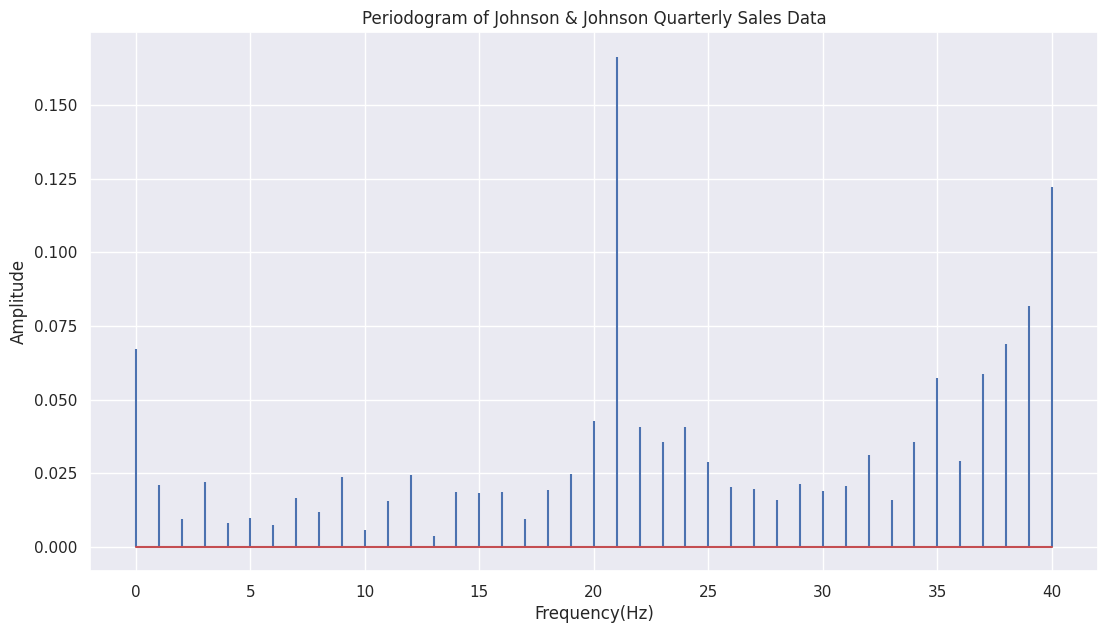

In [ ]:
# perform fft and plot periodogram
periodogram(ts=diff_log_jj.tolist())
plt.title('Periodogram of Johnson & Johnson Quarterly Sales Data')
plt.savefig('periodogram_jj.png', dpi=300, bbox_inches="tight")
plt.show()

## LSTM

In [ ]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(data=diff_log_jj, lag=1)
supervised_values = supervised.values

In [ ]:
# split data into train and test sets
train, test = supervised_values[0:-16], supervised_values[-16:] # around 20% data as test data

In [ ]:
# scale of the data between -1 and 1
scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
# repeat experiment
# forecast of LSTM can be sensitive to initial conditions, so repeat modelling

# create required empty lists
repeats = 30
error_scores = list()
pred_list = list()
# for loop to repeat experiment
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train=train_scaled, batch_size=1, nb_epoch=50,
                          neurons=4)

    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler=scaler, X=X, value=yhat)
        # invert differencing
        yhat = inverse_difference(history=log_jj, yhat=yhat,
                                  interval=len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)

    # report performance
    rmse = np.sqrt(mean_squared_error(log_jj[-16:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    # record predictions and rmse
    pred_list.append(predictions)
    error_scores.append(rmse)

1/1 [==============================] - 0s 17ms/step
1) Test RMSE: 0.181
1/1 [==============================] - 0s 25ms/step
2) Test RMSE: 0.194
1/1 [==============================] - 0s 16ms/step
3) Test RMSE: 0.195
1/1 [==============================] - 0s 15ms/step
4) Test RMSE: 0.205
1/1 [==============================] - 0s 16ms/step
5) Test RMSE: 0.190
1/1 [==============================] - 0s 19ms/step
6) Test RMSE: 0.231
1/1 [==============================] - 0s 29ms/step
7) Test RMSE: 0.204
1/1 [==============================] - 0s 17ms/step
8) Test RMSE: 0.203
1/1 [==============================] - 0s 23ms/step
9) Test RMSE: 0.171
1/1 [==============================] - 0s 16ms/step
10) Test RMSE: 0.203
1/1 [==============================] - 0s 18ms/step
11) Test RMSE: 0.187
1/1 [==============================] - 0s 17ms/step
12) Test RMSE: 0.190
1/1 [==============================] - 0s 15ms/step
13) Test RMSE: 0.225
1/1 [==============================] - 0s 34ms/step
14) Test

            RMSE
count  30.000000
mean    0.196310
std     0.015131
min     0.170649
25%     0.186660
50%     0.194759
75%     0.203349
max     0.231228 



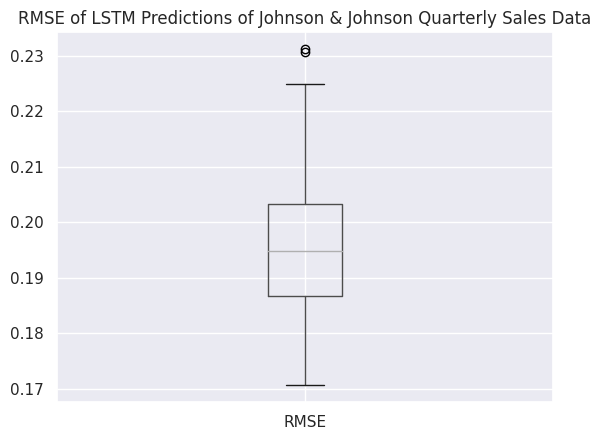

In [ ]:
# summarize results
# make a boxplot of the rmse values
results = pd.DataFrame()
results['RMSE'] = error_scores
print(results.describe(), '\n')

results.boxplot()
plt.title('RMSE of LSTM Predictions of Johnson & Johnson Quarterly Sales Data')
plt.savefig('rmse_jj.png', dpi=300, bbox_inches="tight")
plt.show()

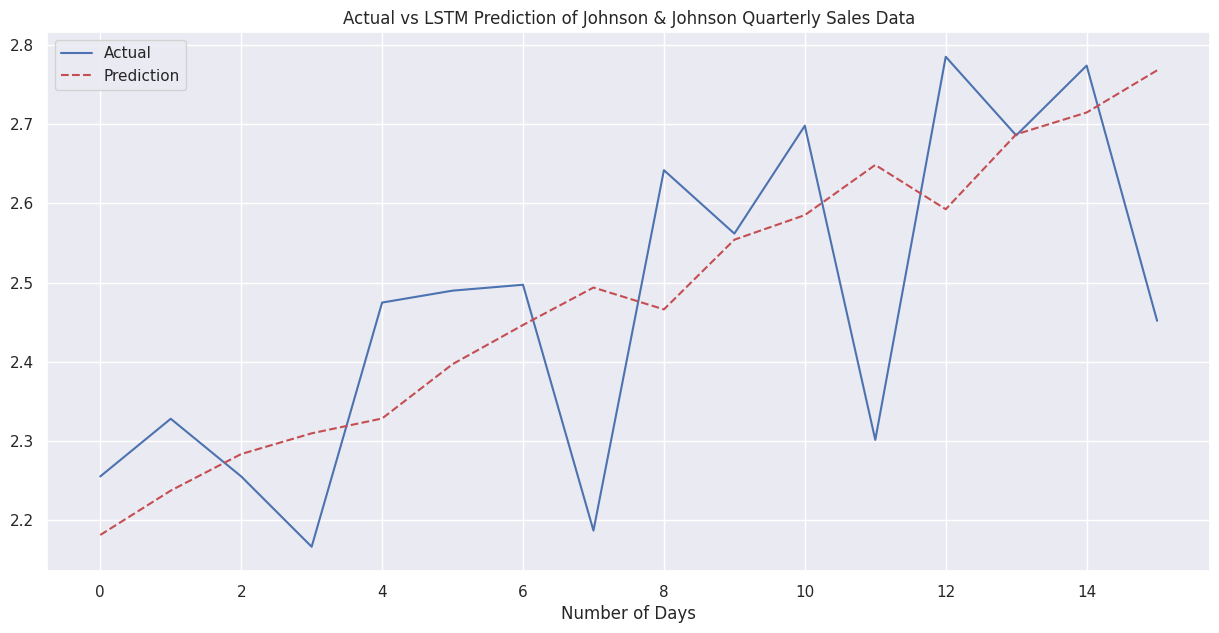

In [ ]:
# plot actual and predicted data
plt.figure(figsize=(15,7))
plt.plot(log_jj[-16:].values, label='Actual')
plt.plot(pred_list[np.argmin(results)], 'r--', label='Prediction')
plt.xlabel('Number of Days')
plt.title('Actual vs LSTM Prediction of Johnson & Johnson Quarterly Sales Data')
plt.legend()
plt.savefig('lstm_pred_jj.png', dpi=300, bbox_inches="tight")
plt.show()

# Amazon

## Load Data

In [ ]:
# read in data file
amzn_df = pd.read_csv('/content/drive/MyDrive/AMZN.csv')
# display the data
amzn_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
1,2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2,2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
3,2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
4,2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


In [ ]:
# display info
amzn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


## Data Preprocessing

In [ ]:
# check for duplicates
check_dup(amzn_df)

Number of duplicated rows = 0


In [ ]:
# convert the 'date' column to datetime format
amzn_df['Date']= pd.to_datetime(amzn_df['Date'])

In [ ]:
# set index
amzn_df.set_index('Date', inplace=True)
amzn_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


In [ ]:
# analyse the data
amzn_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,120.663254,122.124638,119.039742,120.591815,120.591815,8.545871e+07
std,34.824329,35.191093,34.406018,34.756745,34.756745,3.952944e+07
min,67.300003,69.801498,65.349998,67.197998,67.197998,1.762600e+07
25%,89.720249,90.347000,88.685001,89.639252,89.639252,5.876900e+07
50%,108.103500,110.780502,106.320000,108.000000,108.000000,7.434830e+07
75%,158.343750,159.924003,156.199997,158.086998,158.086998,1.007690e+08
max,187.199997,188.654007,184.839493,186.570496,186.570496,3.113460e+08


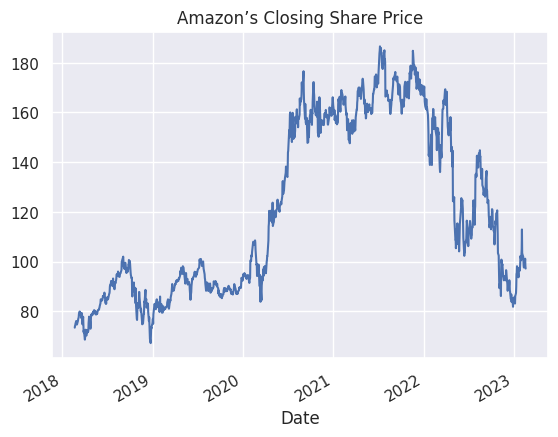

In [ ]:
# plot the time series
amzn_df['Close'].plot()
plt.title('Amazon’s Closing Share Price')
plt.show()

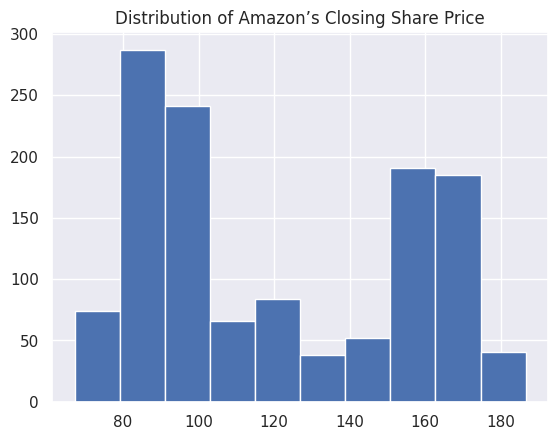

In [ ]:
# plot histogram
amzn_df['Close'].hist()
plt.title('Distribution of Amazon’s Closing Share Price')
plt.show()

## Stationarity

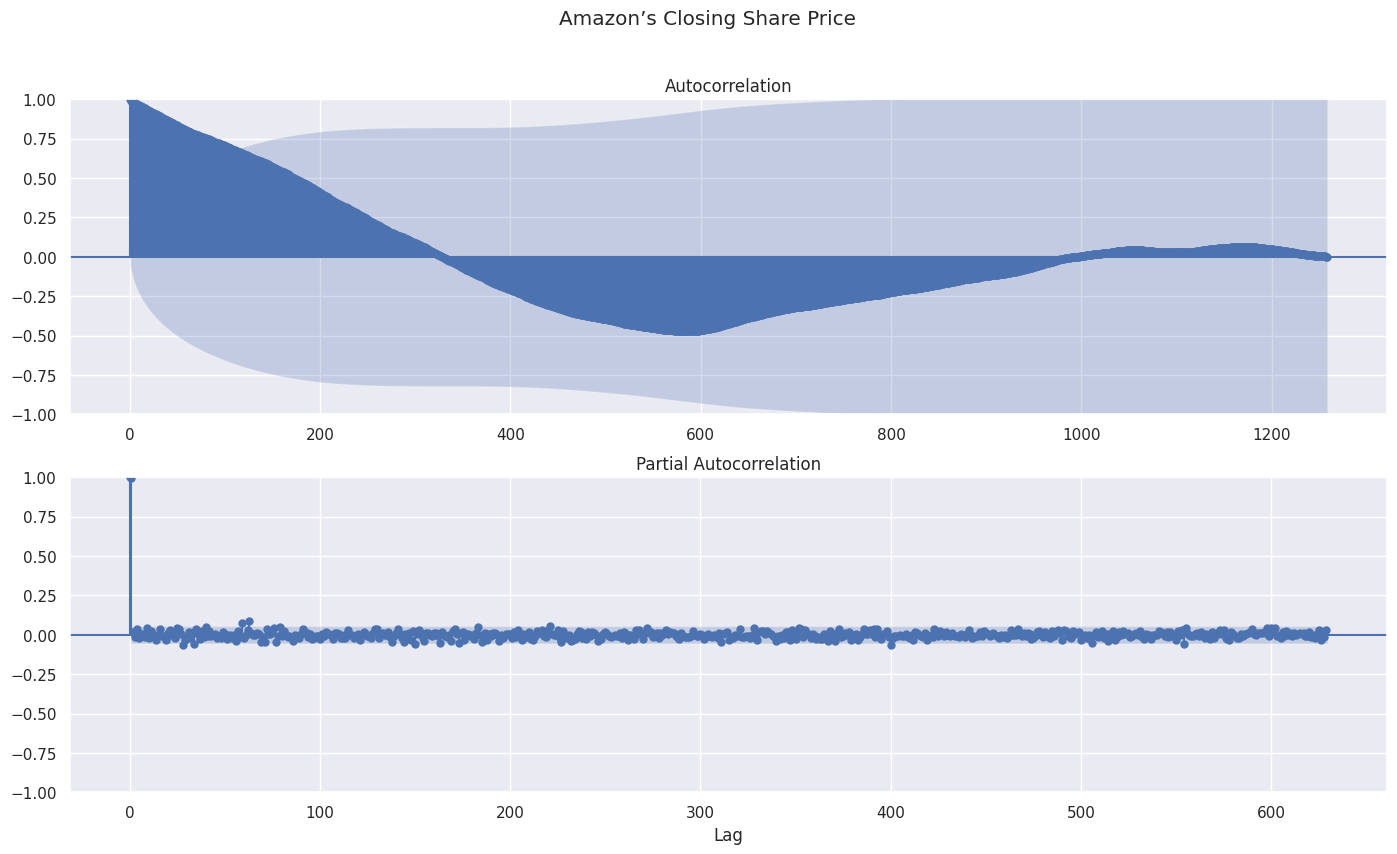

In [ ]:
# plot ACF and PACF
plot_acf_pacf(amzn_df['Close'])
plt.suptitle('Amazon’s Closing Share Price')
plt.show()

In [ ]:
# perform ADF test
adfuller_test(ts=amzn_df['Close'])

ADF Test Statistic : -1.6578089913331728
p-value : 0.45297105465166737
#Lags Used : 0
Number of Observations Used : 1258
Weak evidence against null hypothesis that means time series has a unit root
--> Indicates the time series is non-stationary 


In [ ]:
# find best lambda
boxcox_amzn, lam = boxcox(amzn_df['Close'])

# print lambda
print(f'Lambda = {lam}')

Lambda = -0.36999985006271


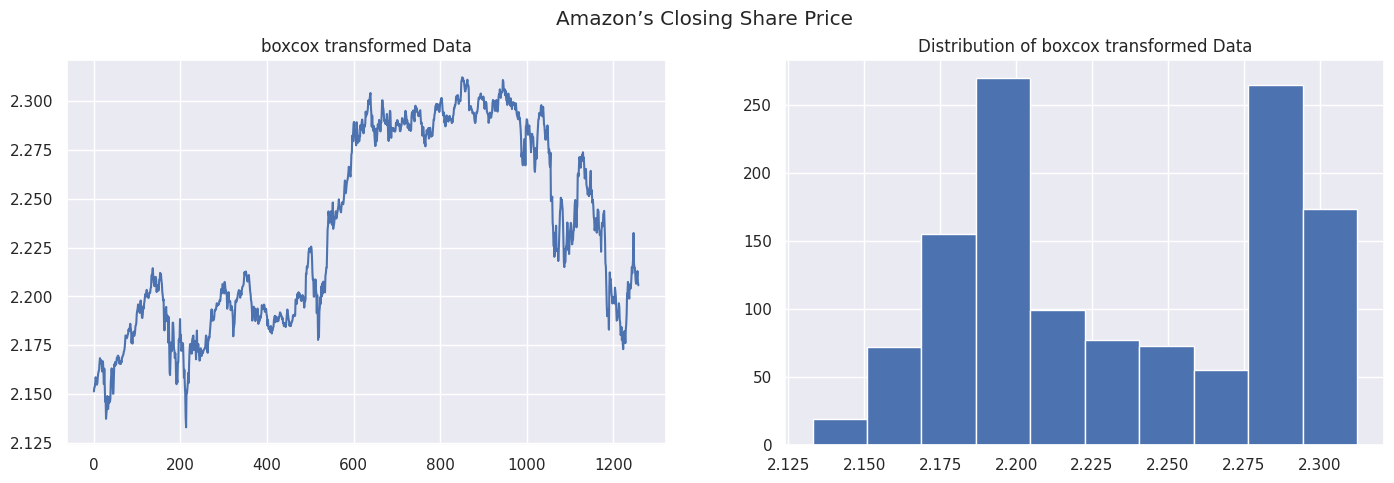

In [ ]:
# plot line plot and histogram
plot_line_hist(boxcox_amzn, 'boxcox')
plt.suptitle('Amazon’s Closing Share Price')
plt.show()

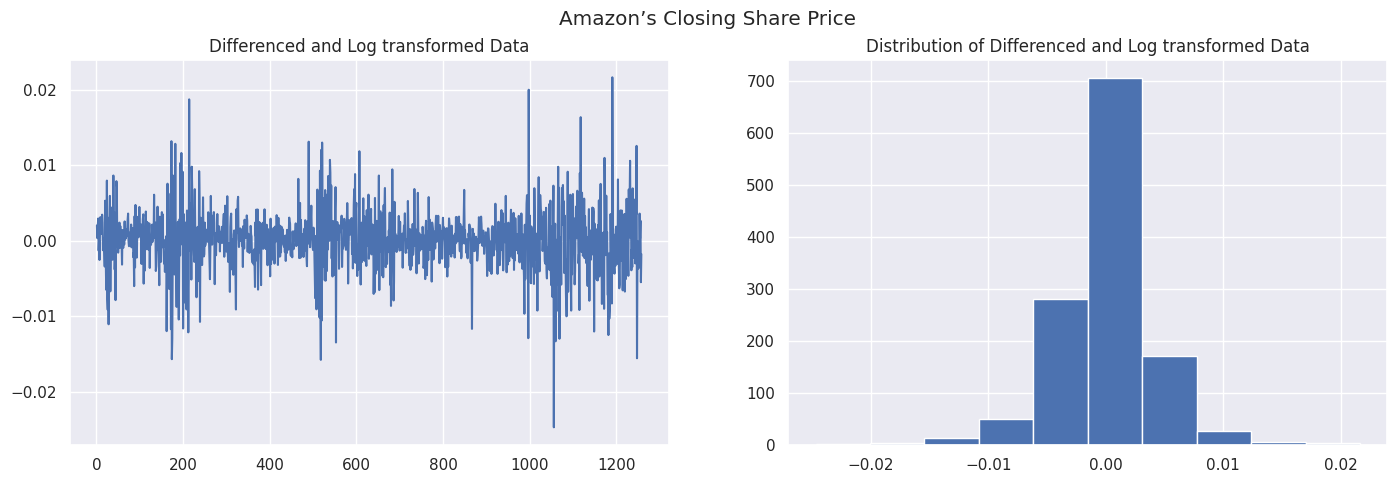

In [ ]:
# convert to Dataframe
boxcox_amzn = pd.DataFrame(boxcox_amzn)
# use the differencing operator
diff_boxcox_amzn = boxcox_amzn.diff().dropna()

# plot
plot_line_hist(diff_boxcox_amzn, 'Differenced and Log')
plt.suptitle('Amazon’s Closing Share Price')
plt.show()

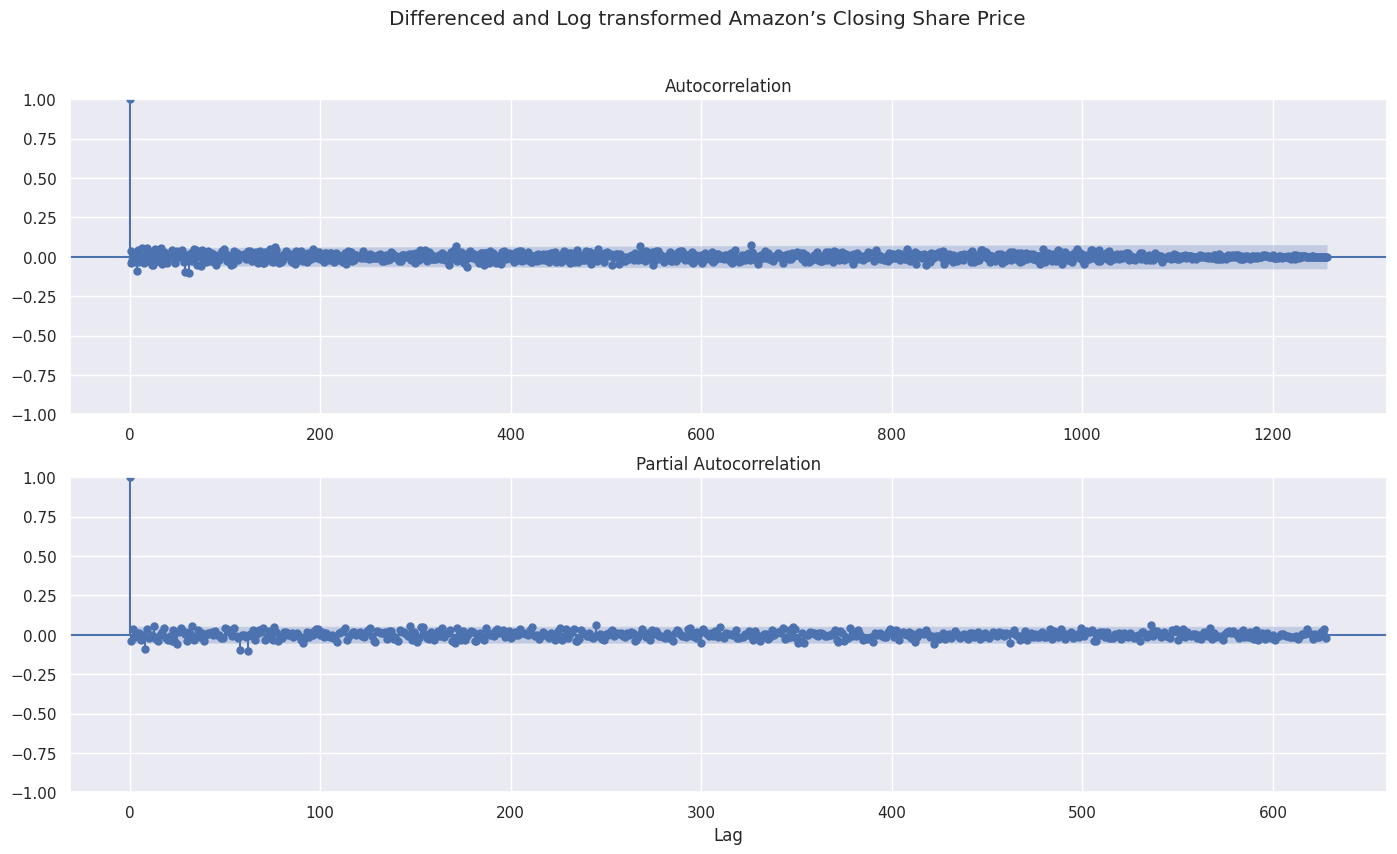

In [ ]:
# plot ACF and PACF
plot_acf_pacf(diff_boxcox_amzn)
plt.suptitle('Differenced and Log transformed Amazon’s Closing Share Price')
plt.show()

In [ ]:
# perform ADF test
adfuller_test(ts=diff_boxcox_amzn)

ADF Test Statistic : -13.829652342502527
p-value : 7.63428151147939e-26
#Lags Used : 7
Number of Observations Used : 1250
P value is less than 0.05 that means we can reject the null hypothesis(Ho).
--> Therefore we can conclude that data has no unit root and is stationary


## ARIMA

In [ ]:
# find best order of arima model with the least AIC
best_order_least_aic, pdq_df = best_arima(ts=amzn_df['Close'].tolist())

ARIMA(2, 1, 2) has the least AIC for the given time series.


In [ ]:
# define the ARIMA model with the best order on actual data
model = ARIMA(amzn_df['Close'], order=best_order_least_aic)

# fit the model
model_fit = model.fit()
# inspect the summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3056.158
Date:                Wed, 01 May 2024   AIC                           6122.315
Time:                        07:49:19   BIC                           6148.002
Sample:                             0   HQIC                          6131.969
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6946      0.015   -111.813      0.000      -1.724      -1.665
ar.L2         -0.9604      0.015    -64.728      0.000      -0.989      -0.931
ma.L1          1.6972      0.011    152.237      0.000       1.675       1.719
ma.L2          0.9786      0.011     90.455      0.000       0.957       1.000
sigma2         7.5418      0.165     45.656      0.000       7.218       7.866
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):              1737.60
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               4.46   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

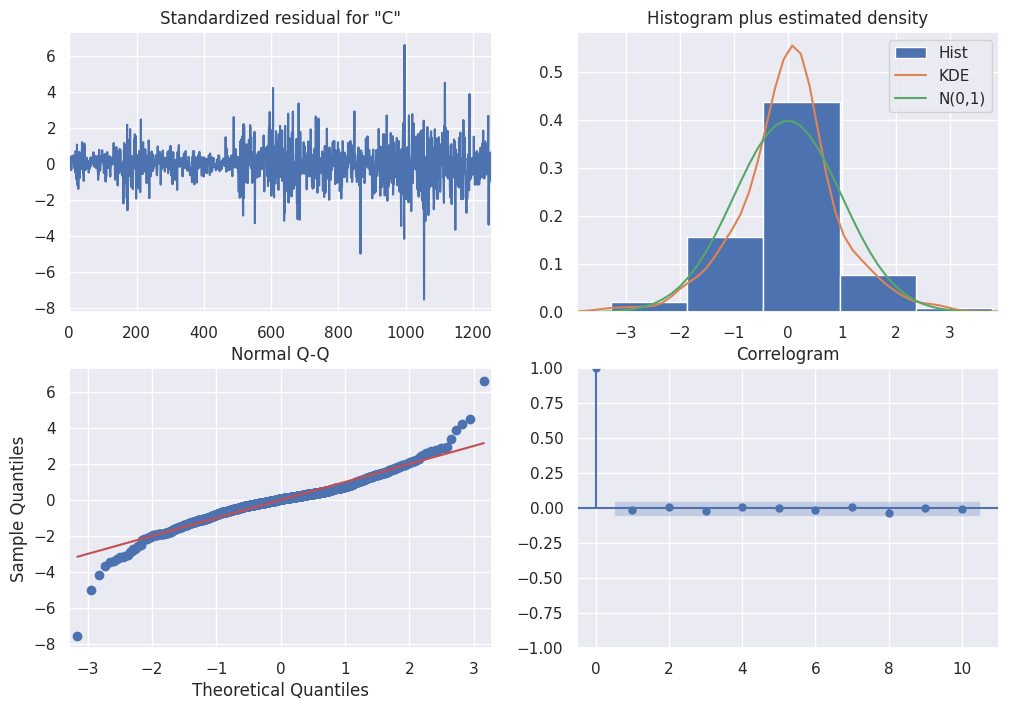

In [ ]:
# plot diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

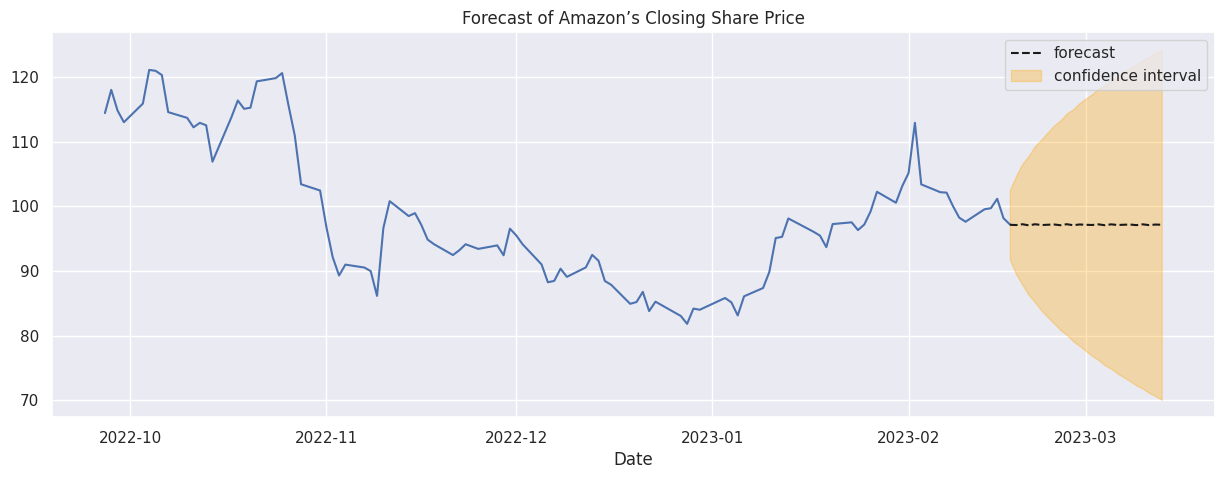

In [ ]:
# get the forecast
n_forecast = 24
predict = model_fit.get_prediction(end=model.nobs + n_forecast)

# create the date range for the forecast period
future_dates = pd.date_range(start=amzn_df.index[-1], periods=n_forecast + 1)
# convert to the same format
future_dates = future_dates.to_period(amzn_df.index.freq)

# plot forecast
plot_forecast(ts=amzn_df['Close'].iloc[-100:], future_dates=future_dates,
              predict=predict, n_forecast=n_forecast)
plt.title('Forecast of Amazon’s Closing Share Price')
plt.savefig('amzn_forecast.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
predict.predicted_mean[(-n_forecast)-1:]

1259    97.138877
1260    97.100049
1261    97.224545
1262    97.050869
1263    97.225609
1264    97.096299
1265    97.147604
1266    97.184852
1267    97.072460
1268    97.227143
1269    97.072963
1270    97.185674
1271    97.142752
1272    97.107240
1273    97.208639
1274    97.070917
1275    97.206913
1276    97.108726
1277    97.144500
1278    97.178177
1279    97.086752
1280    97.209334
1281    97.089415
1282    97.174899
1283    97.145211
Name: predicted_mean, dtype: float64

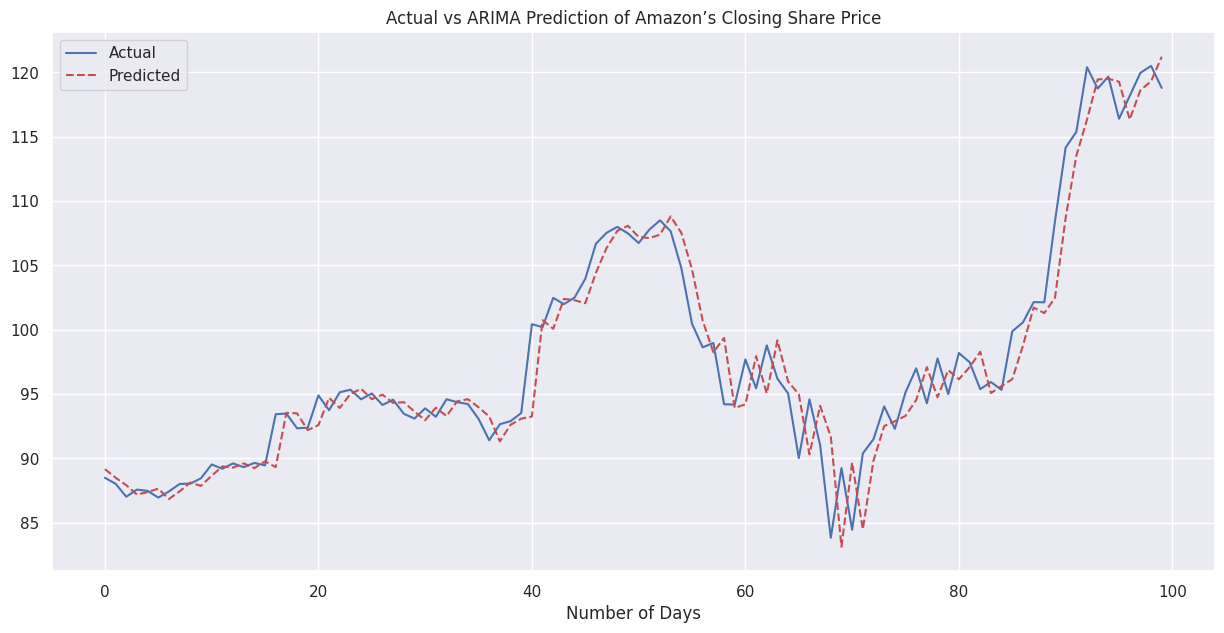

In [ ]:
# evaluate the model
plt.figure(figsize=(15,7))
start, end = 450, 550
plt.plot(amzn_df['Close'][start:end].values, label='Actual')
plt.plot(predict.predicted_mean[:model.nobs][start:end].values, 'r--', label='Predicted')
plt.xlabel('Number of Days')
plt.title('Actual vs ARIMA Prediction of Amazon’s Closing Share Price')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(amzn_df['Close'], predict.predicted_mean[:model.nobs]))
print('RMSE =', np.round(rmse, 3))

RMSE = 3.438


In [ ]:
# find best order of arima model auto_arima
auto_arima_model = auto_arima(amzn_df['Close'].tolist(), stepwise=False)

# obtain best order
best_order_auto = auto_arima_model.order
best_order_auto

(2, 1, 2)

## Fourier transforms

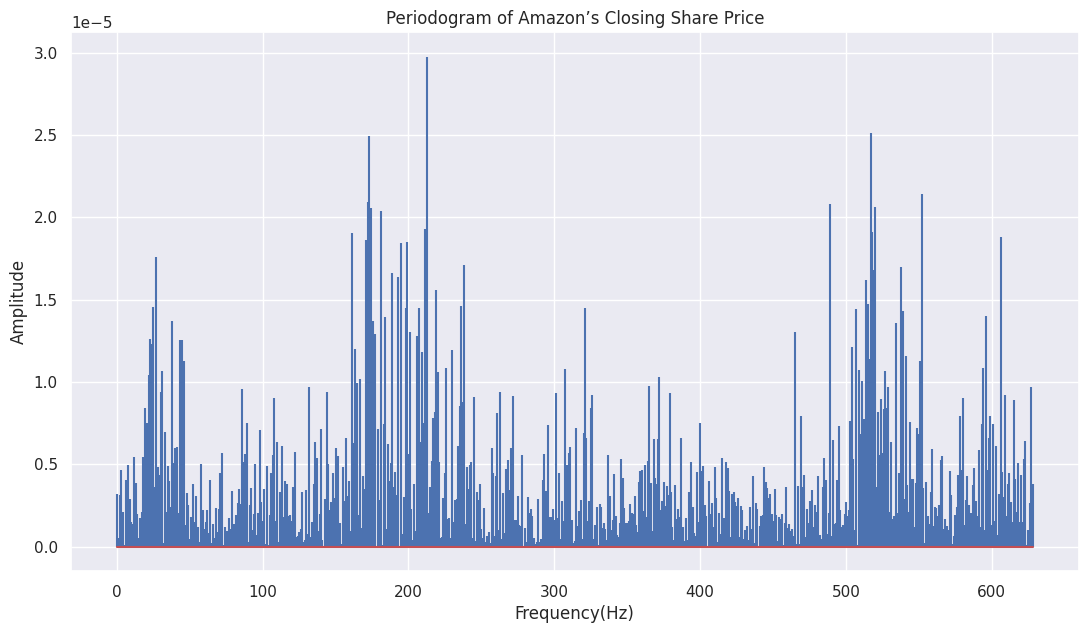

In [ ]:
# perform fft and plot periodogram
periodogram(ts=diff_boxcox_amzn)
plt.title('Periodogram of Amazon’s Closing Share Price')
plt.savefig('periodogram_amzn.png', dpi=300, bbox_inches="tight")
plt.show()

## LSTM

In [ ]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(data=diff_boxcox_amzn, lag=1)
supervised_values = supervised.values

In [ ]:
# split data into train and test sets
train, test = supervised_values[0:-250], supervised_values[-250:]

In [ ]:
# scale the data to -1 and 1
scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
# fit the model
lstm_model = fit_lstm(train=train_scaled, batch_size=1, nb_epoch=50,
                      neurons=4)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
  # make one-step forecast
  X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
  yhat = forecast_lstm(lstm_model, 1, X)
  # invert scaling
  yhat = invert_scale(scaler=scaler, X=X, value=yhat)
  # invert differencing
  yhat = inverse_difference(history=boxcox_amzn.values, yhat=yhat,
                            interval=len(test_scaled)+1-i)
  # store forecast
  predictions.append(yhat)

# report performance
rmse = np.sqrt(mean_squared_error(boxcox_amzn[-250:], predictions))
print('Test RMSE =', np.round(rmse, 3))

1/1 [==============================] - 0s 24ms/step
Test RMSE = 0.005


In [ ]:
rmse

0.005413866395226979

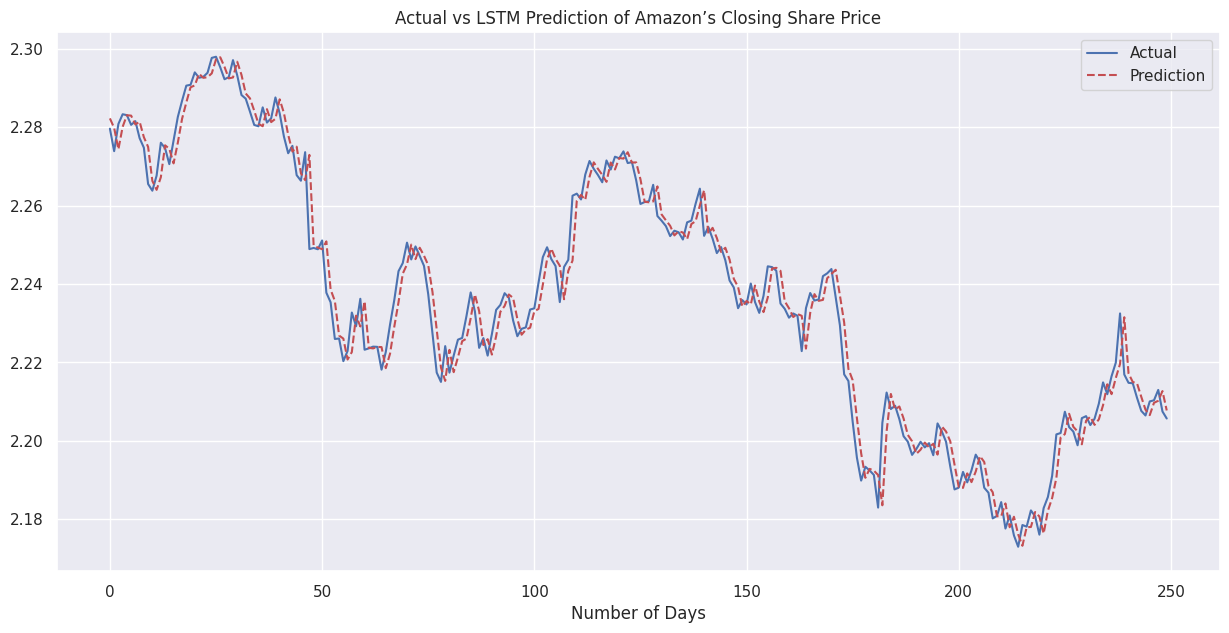

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(boxcox_amzn[-250:].values, label='Actual')
plt.plot(predictions, 'r--', label='Prediction')
plt.xlabel('Number of Days')
plt.title('Actual vs LSTM Prediction of Amazon’s Closing Share Price')
plt.legend()
plt.show()